In [ ]:
!pip install ../input/python-datatable/datatable-0.11.0-cp37-cp37m-manylinux2010_x86_64.whl > /dev/null

In [ ]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import janestreet
import tensorflow as tf
import tensorflow.keras.backend as k
import datatable as dt
import gc
import random
import os
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import tensorflow_addons as tfad

In [ ]:
seed=1111
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
full_train=dt.fread('../input/jane-street-market-prediction/train.csv').to_pandas()
#full_train=pd.read_csv('../input/jane-street-market-prediction/train.csv',low_memory=False,nrows=1.5*10**6)
#full_train=full_train.sort_values(['date', 'ts_id'], ascending=[True, True])
full_train.info()

In [ ]:
# contain_null_indices=full_train.columns[pd.isnull(full_train).any()]
# for item in contain_null_indices:
#     if item.split('_')[0]=='feature':
#         pass
#     else:
#         print(item)
# #nothing prints means all null are in feature named columns...

# fillna using feature.csv avg values

In [ ]:
# feature_info=pd.read_csv('../input/jane-street-market-prediction/features.csv')
# print('null_info : ',feature_info.columns[pd.isnull(feature_info).any()]) # no nulls in feature_info

# mean_value_dict={}            #lets assume these are the values to be filled in the nan portion
# for row in feature_info.values:
#     mean_value_dict[row[0]]=np.mean(row[1:])
    
# full_train.fillna(mean_value_dict,inplace=True)

# filling using mean values from train.csv

In [ ]:
full_train=full_train.query('date>85').reset_index(drop=True)
full_train=full_train[full_train['weight']!=0.0]
train_mean_dict=dict(full_train.drop(['resp','resp_1','resp_2','resp_3','resp_4','date','ts_id'],axis=1).mean())
full_train=full_train.fillna(train_mean_dict)

# making feature importances and x,y

In [ ]:
# scaler=MinMaxScaler()
# x=scaler.fit_transform(x)

# from sklearn.ensemble import RandomForestClassifier
# clf=RandomForestClassifier(n_estimators=100)
# clf.fit(x[:100000],y[:100000,0])

# features=full_train.drop(['resp','resp_1','resp_2','resp_3','resp_4','date','ts_id'],axis=1).columns
# feature_importance = {features[i]: clf.feature_importances_[i] for i in range(len(features))}
# imp=dict(sorted(feature_importance.items(), key=lambda item: item[1]))

# plt.figure(figsize=(10,30))
# plt.barh(range(len(imp)),imp.values())
# plt.ylabel('feature importances')
# plt.xlabel('features available')
# _=plt.yticks(range(len(imp)),imp.keys())
# plt.grid(True)
# plt.savefig('feature_importances.png')


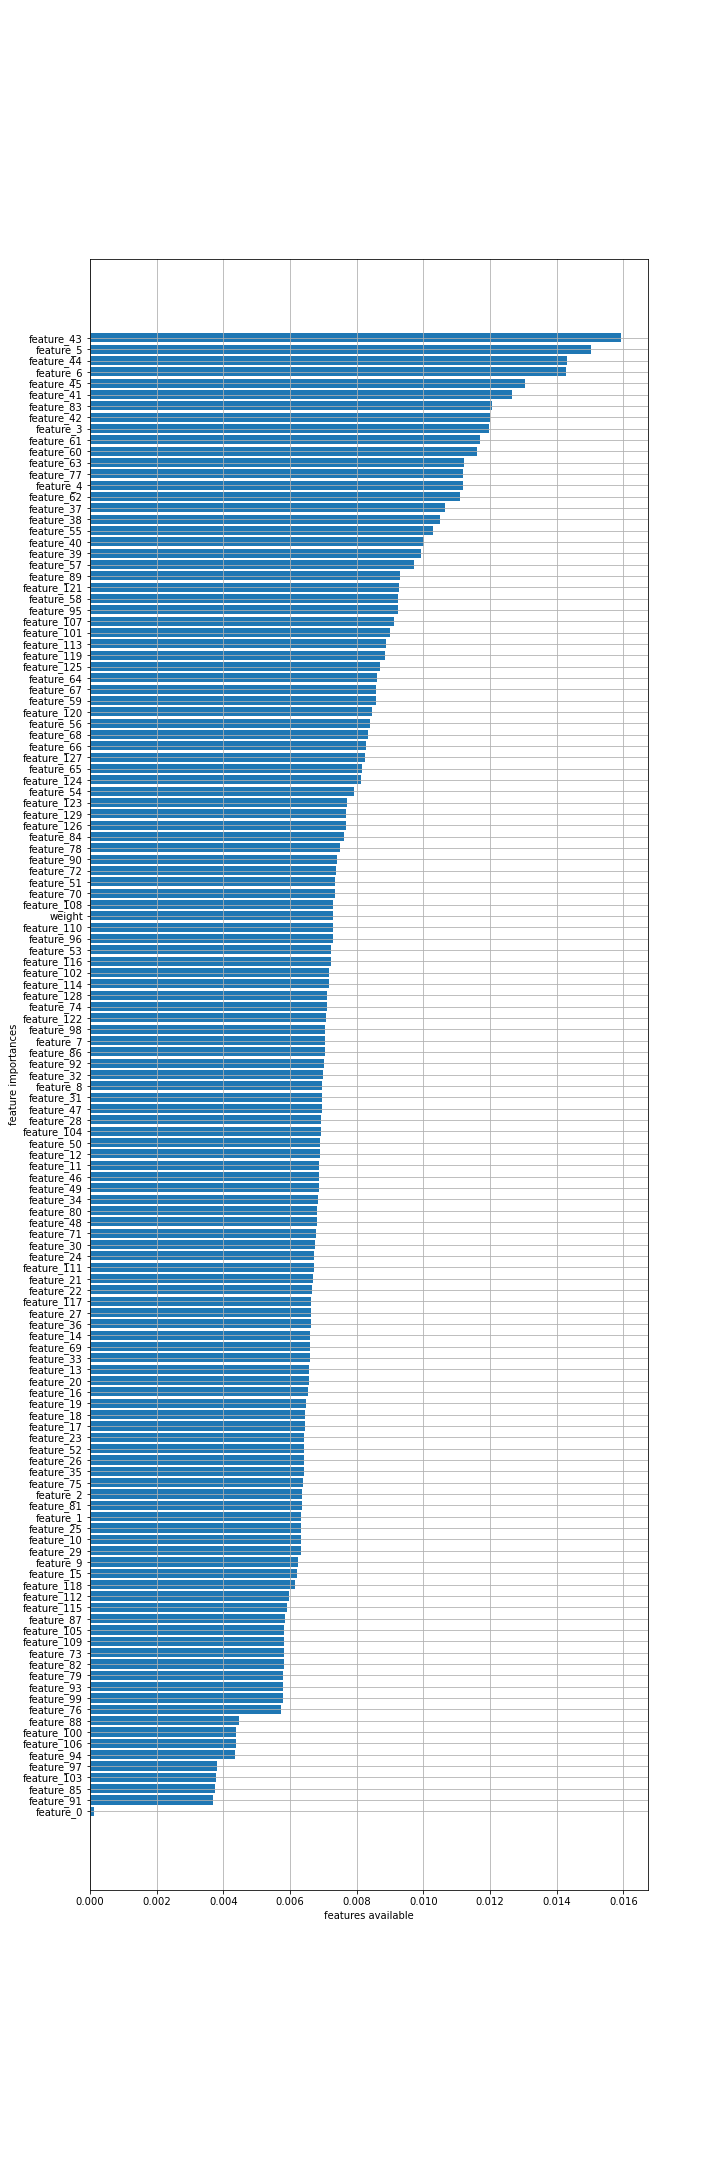
this shows that:   
1. feature_0 is atually useless.  
2. i'll drop all the featurs below 0.004  
we will work on only the rest of the features ..

In [ ]:
features=['feature_0','feature_97','feature_103','feature_85','feature_91','feature_94', 'feature_106', 'feature_100', 'feature_88',
       'feature_76', 'feature_99', 'feature_93', 'feature_79',
       'feature_82', 'feature_73', 'feature_109', 'feature_105',
       'feature_87', 'feature_115', 'feature_112', 'feature_118',
       'feature_15', 'feature_9', 'feature_29', 'feature_10',
       'feature_25', 'feature_1', 'feature_81', 'feature_2', 'feature_75',
       'feature_35', 'feature_26', 'feature_52', 'feature_23',
       'feature_17', 'feature_18', 'feature_19', 'feature_16',
       'feature_20', 'feature_13', 'feature_33', 'feature_69',
       'feature_14', 'feature_36', 'feature_27', 'feature_117',
       'feature_22', 'feature_21', 'feature_111', 'feature_24',
       'feature_30', 'feature_71', 'feature_48', 'feature_80',
       'feature_34', 'feature_49', 'feature_46', 'feature_11',
       'feature_12', 'feature_50', 'feature_104', 'feature_28',
       'feature_47', 'feature_31', 'feature_8', 'feature_32',
       'feature_92', 'feature_86', 'feature_7', 'feature_98',
       'feature_122', 'feature_74', 'feature_128', 'feature_114',
       'feature_102', 'feature_116', 'feature_53', 'feature_96',
       'feature_110','feature_108', 'feature_70', 'feature_51',
       'feature_72', 'feature_90', 'feature_78', 'feature_84',
       'feature_126', 'feature_129', 'feature_123', 'feature_54',
       'feature_124', 'feature_65', 'feature_127', 'feature_66',
       'feature_68', 'feature_56', 'feature_120', 'feature_59',
       'feature_67', 'feature_64', 'feature_125', 'feature_119',
       'feature_113', 'feature_101', 'feature_107', 'feature_95',
       'feature_58', 'feature_121', 'feature_89', 'feature_57',
       'feature_39', 'feature_40', 'feature_55', 'feature_38',
       'feature_37', 'feature_62', 'feature_4', 'feature_77',
       'feature_63', 'feature_60', 'feature_61', 'feature_3',
       'feature_42', 'feature_83', 'feature_41', 'feature_45',
       'feature_6', 'feature_44', 'feature_5', 'feature_43']
#weight only removed

In [ ]:
x=full_train.loc[:,features]
resp_cols = ['resp', 'resp_1', 'resp_2', 'resp_3','resp_4']
y= np.stack([(full_train[col] > 0).astype('int') for col in resp_cols]).T

# making model

In [ ]:
# losses=[tf.keras.losses.BinaryCrossentropy(label_smoothing=1e-2),
#        tf.keras.losses.BinaryCrossentropy(label_smoothing=1e-2),
#        tf.keras.losses.BinaryCrossentropy(label_smoothing=1e-2),
#        tf.keras.losses.BinaryCrossentropy(label_smoothing=1e-2),
#        tf.keras.losses.BinaryCrossentropy(label_smoothing=1e-2)]
# loss_weights=[1.0,0.3,0.3,0.3,0.3]

In [ ]:
# class SquareRootScheduler:
#     def __init__(self, lr=0.1):
#         self.lr = lr

#     def __call__(self, num_update):
#         return self.lr * pow(num_update + 1.0, -0.5)

In [ ]:
inputs = tf.keras.layers.Input(shape=x.shape[1:])
#encoded = tf.keras.layers.BatchNormalization()(inputs)
#encoded = tf.keras.layers.GaussianNoise(0.1)(encoded)
#encoded = tf.keras.layers.Dense(64,activation='relu')(encoded)
#decoded = tf.keras.layers.Dropout(0.2)(encoded)
#decoded = tf.keras.layers.Dense(x.shape[1],name='decoded')(decoded)

############################################################################

#inp_norm=tf.keras.layers.BatchNormalization()(decoded)
inp_norm=tf.keras.layers.BatchNormalization()(inputs)
inp_drop=tf.keras.layers.Dropout(0.2)(inp_norm)

dense1=tf.keras.layers.Dense(160)(inp_drop)
norm1=tf.keras.layers.BatchNormalization()(dense1)
act1=tf.keras.layers.Activation(tf.keras.activations.swish)(norm1)
drop1=tf.keras.layers.Dropout(0.2)(act1)

dense2=tf.keras.layers.Dense(160)(drop1)
norm2=tf.keras.layers.BatchNormalization()(dense2)
act2=tf.keras.layers.Activation(tf.keras.activations.swish)(norm2)
drop2=tf.keras.layers.Dropout(0.2)(act2)

dense3=tf.keras.layers.Dense(160)(drop2)
norm3=tf.keras.layers.BatchNormalization()(dense3)
act3=tf.keras.layers.Activation(tf.keras.activations.swish)(norm3)
drop3=tf.keras.layers.Dropout(0.2)(act3)

out=tf.keras.layers.Dense(5, activation='sigmoid',name='out')(drop3)
#model=tf.keras.models.Model(inputs=[inputs],outputs=[decoded,out],name='my_baseline_model')
model=tf.keras.models.Model(inputs=[inputs],outputs=[out],name='my_baseline_model')

#model.compile(loss={'decoded':'mse','out':'binary_crossentropy'},optimizer=tf.keras.optimizers.Adam(lr=0.001,decay=0.0001))
model.compile(loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=1e-2),optimizer=tfad.optimizers.RectifiedAdam(learning_rate=1e-3))

model.summary()

In [ ]:
# class print_lr_callback(tf.keras.callbacks.Callback):
#     def on_epoch_begin(self,epoch,logs=None):
#         print('lr now : ',self.model.optimizer.lr.numpy())

In [ ]:
#history=model.fit(x,(x,y),epochs=100,batch_size=10000,verbose=1)
history=model.fit(x,y,epochs=200,batch_size=10000,verbose=1)

In [ ]:
model.save('model.h5')

In [ ]:
#now for the predictions
janestreet.competition.make_env.__called__ = False
env = janestreet.make_env() # initialize the environment
iter_test = env.iter_test() # an iterator which loops over the test set

In [ ]:
filling_dict=train_mean_dict

model.call = tf.function(model.call, experimental_relax_shapes=True)
for (test_df, sample_prediction_df) in tqdm(iter_test):
        
    if test_df['weight'].item()>0:
        test_df=test_df.loc[:,features]
        for key in features:
            if np.isnan(np.array(test_df[key])[0]):
                test_df[key]=filling_dict[key] 
                
        #preds=model(test_df,training=False)[1].numpy()
        preds=model(test_df,training=False).numpy()
        sample_prediction_df.action=(np.mean(preds) > 0.503).astype(int)
    else:
        sample_prediction_df.action=0
    

    env.predict(sample_prediction_df)